In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

device = "cuda"
#device = "cpu"
load_weight = True
save_dir        = "./"
weight_float32  = "mnist_model.pt"
weight_qint8    = "mnist_model_int8.pt"


In [ ]:
# int8: -128~127
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
#transform = transforms.Compose([transforms.ToTensor(),])

In [ ]:
trainset = datasets.MNIST('./trainset', download=True, train=True, transform=transform)
#trainset = datasets.MNIST('./trainset', download=True, train=True)

valset = datasets.MNIST('./testset', download=True, train=False, transform=transform)
#valset = datasets.MNIST('./testset', download=True, train=False)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)


Extracting ./trainset/MNIST/raw/train-images-idx3-ubyte.gz to ./trainset/MNIST/raw




Extracting ./trainset/MNIST/raw/train-labels-idx1-ubyte.gz to ./trainset/MNIST/raw




Extracting ./trainset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./trainset/MNIST/raw




Extracting ./trainset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./trainset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)



Extracting ./testset/MNIST/raw/train-images-idx3-ubyte.gz to ./testset/MNIST/raw




Extracting ./testset/MNIST/raw/train-labels-idx1-ubyte.gz to ./testset/MNIST/raw




Extracting ./testset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./testset/MNIST/raw




Extracting ./testset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./testset/MNIST/raw



In [ ]:
print(trainset)
dataiter = iter(trainloader)
images, labels = dataiter.next()
#images = transforms.functional.convert_image_dtype(images, torch.int8)
#print(type(dataiter))
#for p in dataiter:
#    print(p)

print(images.shape)
print(labels.shape)
#print(images[0].numpy())


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./trainset
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
torch.Size([64, 1, 28, 28])
torch.Size([64])


array([[[-1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ],
        [-1.        , -1.        , -1.        , -1.        ,
         -1.        , -1.        , -1.        , -1.        ,
         -1.        , 

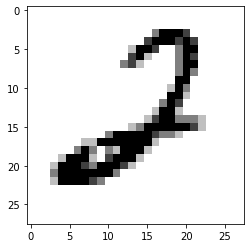

In [ ]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');
images[0].numpy()

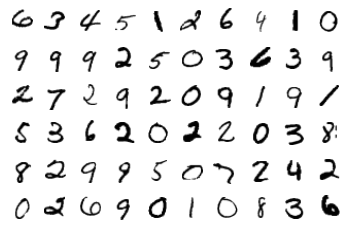

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [ ]:
import os
input_size = 784
hidden_sizes = [128, 64]
output_size = 10
"""
model = nn.Sequential(torch.quantization.QuantStub(),
                      nn.Linear(input_size, hidden_sizes[0]),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.Linear(hidden_sizes[1], output_size),
                      torch.quantization.DeQuantStub(),
                      nn.LogSoftmax(dim=1))
"""

class M(torch.nn.Module):
    def __init__(self):
        super(M, self).__init__()
        self.quant   = torch.quantization.QuantStub()
        self.FC1     = torch.nn.Linear(input_size, hidden_sizes[0])
        self.FC2     = torch.nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.FC3     = torch.nn.Linear(hidden_sizes[1], output_size)
        self.dequant = torch.quantization.DeQuantStub()
        self.lgs     = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.quant(x)
        x = self.FC1(x)
        x = self.FC2(x)
        x = self.FC3(x)
        x = self.dequant(x)
        return self.lgs(x)

model = M()
model.train()
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
#model.qconfig = torch.quantization.qconfig.QConfig(activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8), weight=torch.quantization.default_observer.with_args(dtype=torch.qint8))
model = torch.quantization.prepare_qat(model)
model.to(device)


/usr/local/lib/python3.7/dist-packages/torch/quantization/observer.py:124: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  reduce_range will be deprecated in a future release of PyTorch."


M(
  (quant): QuantStub(
    (activation_post_process): FakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=0, quant_max=255, dtype=torch.quint8, qscheme=torch.per_tensor_affine, ch_axis=-1, scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0')
      (activation_post_process): MovingAverageMinMaxObserver(min_val=inf, max_val=-inf)
    )
  )
  (FC1): Linear(
    in_features=784, out_features=128, bias=True
    (weight_fake_quant): FakeQuantize(
      fake_quant_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), observer_enabled=tensor([1], device='cuda:0', dtype=torch.uint8), quant_min=-128, quant_max=127, dtype=torch.qint8, qscheme=torch.per_channel_symmetric, ch_axis=0, scale=tensor([1.], device='cuda:0'), zero_point=tensor([0], device='cuda:0')
      (activation_post_process): MovingAveragePerChannelMinMaxObserver(min_val=tensor([], device='cuda

In [ ]:
criterion = nn.NLLLoss().to(device)
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1).to(device)
labels = labels.to(device)

logps = model(images) #log probabilities
loss = criterion(logps, labels) #calculate the NLL loss

In [ ]:
#print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
#print('After backward pass: \n', model[0].weight.grad)

In [ ]:
if not load_weight:
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    time0 = time()
    epochs = 100
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            # Flatten MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1).to(device)
            labels = labels.to(device)
            
            # Training pass
            optimizer.zero_grad()
            
            output = model(images)
            loss = criterion(output, labels)
            
            #This is where the model learns by backpropagating
            loss.backward()
            
            #And optimizes its weights here
            optimizer.step()
            
            running_loss += loss.item()
        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    torch.save(model.state_dict(), os.path.join(weight_float32))
else:
    model.load_state_dict(torch.load(os.path.join(save_dir, weight_float32)))

FileNotFoundError: ignored

Predicted Digit = 6
<class 'torch.Tensor'>


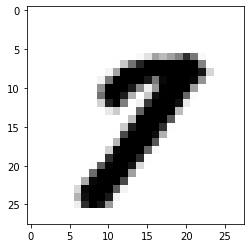

In [ ]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784).to(device)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.to("cpu").numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
print(type(img.view(1, 28, 28)))
plt.imshow(img.view(1, 28, 28).to("cpu").numpy().squeeze(), cmap='gray_r');

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784).to(device)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.to("cpu").numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

KeyboardInterrupt: ignored

In [ ]:
# Quantization
model.to("cpu")
model_int8 = torch.quantization.convert(model, remove_qconfig=False)
if (load_weight):
    model_int8.load_state_dict(torch.load(weight_qint8))

In [ ]:
print(model_int8)
torch.save(model_int8.state_dict(), os.path.join(save_dir, weight_qint8))
model_int8.FC1

M(
  (quant): Quantize(scale=tensor([0.0157]), zero_point=tensor([64]), dtype=torch.quint8)
  (FC1): QuantizedLinear(in_features=784, out_features=128, scale=0.04896312952041626, zero_point=70, qscheme=torch.per_channel_affine)
  (FC2): QuantizedLinear(in_features=128, out_features=64, scale=0.0630040392279625, zero_point=65, qscheme=torch.per_channel_affine)
  (FC3): QuantizedLinear(in_features=64, out_features=10, scale=0.1615007370710373, zero_point=61, qscheme=torch.per_channel_affine)
  (dequant): DeQuantize()
  (lgs): LogSoftmax(dim=1)
)


QuantizedLinear(in_features=784, out_features=128, scale=0.04896312952041626, zero_point=70, qscheme=torch.per_channel_affine)

In [ ]:
correct_count, all_count = 0, 0
model_int8 = model_int8.to("cpu")
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    plt.imshow(img.reshape((28, 28)), "gray_r")
    #img = torch.quantize_per_tensor(img, q_scale, q_zero_point, torch.quint8).int_repr()
    with torch.no_grad():
        logps = model_int8(img.to("cpu"))

    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.9174
Error in callback <function flush_figures at 0x7f2a8806db00> (for post_execute):


KeyboardInterrupt: ignored

#Comparing values

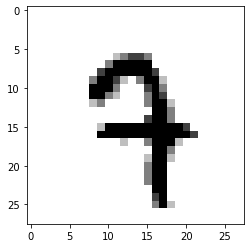

In [ ]:
# Test
images, labels = next(iter(valloader))

img = images[0].view(1, 784)

plt.imshow(img.view(1, 28, 28).numpy().squeeze(), cmap='gray_r');

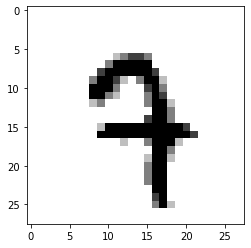

In [ ]:
# Quantized img
img_quint8 = model_int8.quant(img)
plt.imshow(img_quint8.int_repr().view(1, 28, 28).numpy().squeeze(), cmap='gray_r')

In [ ]:
# Preparing weights for numpy
import os

weights_dir = os.path.join("./")

def quant(r:np.ndarray, s:float, z:int) -> float:
    return np.rint((r/s)+z).astype(int)

def dequant(q:np.ndarray, s:float, z:int) -> int:
    return (q-z)*s

class QInt8_Vector:
    def __init__(self, real_num:np.ndarray, scale:float, zero_point:int):
        self.values = quant(real_num, scale, zero_point)
        self.s = scale
        self.z = zero_point
    
    def get_value(self, int_repr=False):
        if (not int_repr):
            return dequant(self.values, self.s, self.z)
        else:
            return self.values
    
    def shape(self):
        return self.values.shape
    
    def quantized(self):
        return self.values
    
    def dequantized(self):
        return dequant(self.values, self.s, self.z)

class FullyConnectedLayer:
    def __init__(self, weights_file:str, bias_file:str, scale:float, zero_point:int):
        self.weights = np.load(os.path.join(weights_dir, weights_file))
        #self.bias = np.load(os.path.join(weights_dir, bias_file))
        self.bias = np.load(os.path.join(weights_dir, bias_file))
        self.s = scale
        self.z = zero_point

    def forward(self, x:QInt8_Vector):
        ret = QInt8_Vector(np.matmul(x.dequantized(), dequant(self.weights.transpose(), x.s, x.z))+self.bias, self.s, self.z)
        #ret = ret - self.z*np.sum(x.values, axis=1)
        #ret = ret - np.sum(self.weights, axis=1)*x.z
        #ret = ret + self.z*x.z*x.values.shape[1]
        #ret = dequantize(ret, self.s, self.z)
        #ret = ret + quantize(self.bias.values, self.s, self.z)
        #ret = ret + dequantize(self.bias.values, self.s, self.z)
        return ret

    def print(self, int_repr=False):
        if int_repr:
            print(self.weights)
        else:
            print((self.weights+self.z)*self.s)

input_scale      = 0.015740957111120224
input_zero_point = 64
FC1_scale        = 0.04896312952041626
FC1_zero_point   = 70
FC2_scale        = 0.0630040392279625
FC2_zero_point   = 65
FC3_scale        = 0.1615007370710373
FC3_zero_point   = 61

FC1 = FullyConnectedLayer(weights_file="FC1_w.npy", bias_file="FC1_b.npy", scale=FC1_scale, zero_point=FC1_zero_point)
FC2 = FullyConnectedLayer(weights_file="FC2_w.npy", bias_file="FC2_b.npy", scale=FC2_scale, zero_point=FC2_zero_point)
FC3 = FullyConnectedLayer(weights_file="FC3_w.npy", bias_file="FC3_b.npy", scale=FC3_scale, zero_point=FC3_zero_point)


In [ ]:
# PyTorch Model
#x1 = model_int8.quant(img)
input_data = torch.quantize_per_tensor(torch.tensor(dequant(np.identity(img.shape[1]), input_scale, input_zero_point)).to(torch.float32), input_scale, input_zero_point, torch.quint8)
x1 = input_data
print(f"Input Layer[{x1.shape}]: {x1.int_repr()}")
x1 = model_int8.FC1(x1)
print(f"FC1 Layer[{x1.shape}]: {x1.int_repr()}")
x1 = model_int8.FC2(x1)
print(f"FC2 Layer[{x1.shape}]: {x1.int_repr()}")
x1 = model_int8.FC3(x1)
print(f"FC3 Layer[{x1.shape}]: {x1.int_repr()}")
#print(x)

Input Layer[torch.Size([784, 784])]: tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]], dtype=torch.uint8)
FC1 Layer[torch.Size([784, 128])]: tensor([[77, 78, 89,  ..., 66, 57, 49],
        [77, 78, 89,  ..., 66, 57, 49],
        [77, 78, 89,  ..., 66, 57, 49],
        ...,
        [77, 78, 89,  ..., 66, 57, 49],
        [77, 78, 89,  ..., 66, 56, 49],
        [77, 78, 89,  ..., 66, 56, 49]], dtype=torch.uint8)
FC2 Layer[torch.Size([784, 64])]: tensor([[77, 78, 59,  ..., 75, 79, 65],
        [77, 78, 59,  ..., 75, 79, 65],
        [77, 78, 59,  ..., 75, 79, 65],
        ...,
        [76, 78, 59,  ..., 75, 79, 65],
        [77, 78, 59,  ..., 75, 79, 65],
        [76, 78, 59,  ..., 75, 79, 65]], dtype=torch.uint8)
FC3 Layer[torch.Size([784, 10])]: tensor([[53, 66, 60,  ..., 63, 46, 54],
        [53, 66, 60,  ..., 63, 46, 54

In [ ]:
# Comparing each layers' output

# Input Layer (Quantization)
print("Input Layer comparing...")
#x1 = model_int8.quant(img)
x1 = input_data
#x2 = QInt8_Vector(img.numpy(), input_scale, input_zero_point)
x2 = QInt8_Vector(x1.dequantize().numpy(), input_scale, input_zero_point)
if ((x1.int_repr().numpy() == x2.get_value(int_repr=True)).all()):
    print("Matching!")
else:
    print("Mismatching!")
    print(f"    x1:{x1.int_repr().numpy()}")
    print(f"    x2:{x2.get_value(int_repr=True)}")

# FC1 Layer
print("FC1 Layer comparing...")
x1 = model_int8.FC1(x1)
#x2 = FC1.forward(x2)
#print(x2.dequantized())
#print(img)
x2 = (np.matmul(x2.dequantized(), FC1.weights.transpose())+FC1.bias+FC1_zero_point)*FC1_scale
print(x1)
print(x2)
#x2 = quant(x1.dequantize().numpy(), FC1_scale, FC1_zero_point)
if ((x1.int_repr().numpy() == x2.quantized()).all()):
    print("Matching!")
else:
    print("Mismatching!")
    print(f"    x1:{x1.int_repr().numpy()}")
    print(f"    x2:{x2.get_value(int_repr=True)}")

print("FC2 Layer comparing...")
x1 = model_int8.FC2(x1)
x2 = FC2.forward(x2)
if ((x1.int_repr().numpy() == x2).all()):
    print("Matching!")
else:
    print("Mismatching!")
    print(f"    x1:{x1.int_repr().numpy()}")
    print(f"    x2:{x2.get_value(int_repr=True)}")

print("FC3 Layer comparing...")
x1 = model_int8.FC3(x1)
x2 = FC3.forward(x2)
if ((x1.int_repr().numpy() == x2).all()):
    print("Matching!")
else:
    print("Mismatching!")
    print(f"    x1:{x1.int_repr().numpy()}")
    print(f"    x2:{x2.get_value(int_repr=True)}")


Input Layer comparing...
Matching!
FC1 Layer comparing...
tensor([[ 0.3427,  0.3917,  0.9303,  ..., -0.1959, -0.6365, -1.0282],
        [ 0.3427,  0.3917,  0.9303,  ..., -0.1959, -0.6365, -1.0282],
        [ 0.3427,  0.3917,  0.9303,  ..., -0.1959, -0.6365, -1.0282],
        ...,
        [ 0.3427,  0.3917,  0.9303,  ..., -0.1959, -0.6365, -1.0282],
        [ 0.3427,  0.3917,  0.9303,  ..., -0.1959, -0.6855, -1.0282],
        [ 0.3427,  0.3917,  0.9303,  ..., -0.1959, -0.6855, -1.0282]],
       size=(784, 128), dtype=torch.quint8,
       quantization_scheme=torch.per_tensor_affine, scale=0.04896312952041626,
       zero_point=70)
[[ 14.75844375  22.93700083  31.28231755 ...  -3.58651087 -39.91932354
  -58.92404389]
 [ 14.77077537  22.93545938  31.30235644 ...  -3.57417925 -39.93319662
  -58.9533315 ]
 [ 14.77000465  22.96089335  31.28540046 ...  -3.57340852 -39.90159683
  -58.93175116]
 ...
 [ 14.76615101  22.92621066  31.29696136 ...  -3.55799399 -39.93165516
  -58.9564144 ]
 [ 14.7777

AttributeError: ignored

#Numpy test

In [ ]:
model_int8(transforms.functional.convert_image_dtype(images[0], torch.float32).reshape((1, 28*28)))

In [ ]:
i = 6
print(images_numpy[i])
x = np.matmul(images_numpy[i], FC1.transpose())
print(f"input:{images_numpy[i].shape}, FC1:{FC1.shape}, output:{x.shape}")
x = np.matmul(x, FC2)
print(f"input:{images_numpy[i].shape}, FC2:{FC2.shape}, output:{x.shape}")
x = np.matmul(x, FC3.transpose())
print(f"input:{images_numpy[i].shape}, FC3:{FC3.shape}, output:{x.shape}")
m = nn.LogSoftmax()
x = transforms.functional.convert_image_dtype(torch.tensor(x), torch.float32)
x = m(x)
x = torch.exp(x)
probab = list(x.numpy())
pred_label = probab.index(max(probab))
print(pred_label)
plt.imshow(images_numpy[i].reshape((28, 28)), cmap="gray_r")
print(f"result:{x}")

In [ ]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model_int8(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

In [ ]:
model.FC1.weight = 